In [1]:
from pathlib import Path

import pandas as pd

from tqdm import tqdm
import pul_config
import importlib

importlib.reload(pul_config)

import utils

importlib.reload(utils)
from utils import (
    build_proba_df_obl,
    build_ranked_lists,
    load_grid_searches,
    score_df_from_grid_searches,
    train,
)

# CHANGE HERE
input_dirs = [
    Path("1_outputs/standard/"),
    Path("1_outputs/small_DS/"),
    Path("1_outputs/large/"),
    Path("1_outputs/large_small_DS/"),
]
output_dirs = [
    Path("2_outputs/standard/"),
    Path("2_outputs/small_DS/"),
    Path("2_outputs/large/"),
    Path("2_outputs/large_small_DS/"),
]
method = "LocalOutlierFactor"
pul_cfg = pul_config.LocalOutlierFactorConfig

remote_method = "LocalOutlierFactor"  # name of the output in S3
# -----

local_method = method
# MODEL_NAMES = ('RotatE', 'TransE', )
MODEL_NAMES = ("RotatE", "TransE", "CompGCN")
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [ ]:
N_JOBS = 40
CV = 5
rerun = False

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(
        input_dir=input_dir,
        output_dir=output_dir,
        model_names=MODEL_NAMES,
        cv=CV,
        n_jobs=N_JOBS,
        pul_cfg=pul_cfg,
        rerun=rerun,
    )

## Evaluation

In [ ]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [ ]:
score_dfs = [
    score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / "score_df.csv")

In [10]:
score_dfs[0].groupby("model_name").mean()

/tmp/ipykernel_52844/1470429527.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[0].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
CompGCN,0.5,3.4,0.4,3.3,0.9,7.8,9623.901616,0.000977,0.016767,2177.9224,0.002746,-0.116370,2701.4,1074.6,96.5,28.5,13140.5,5815.5,392.1,226.9
RotatE,1.0,2.8,0.8,4.5,1.4,8.5,9834.547658,0.001476,-0.004756,2274.3520,0.003091,-0.165822,2502.2,1273.8,94.2,30.8,11715.0,7241.0,363.9,255.1
TransE,0.6,3.2,0.2,1.7,1.3,6.7,11933.816155,0.000985,-0.219252,2412.9240,0.002210,-0.236884,2560.3,1215.7,98.0,27.0,11395.1,7560.9,427.8,191.2


Text(0, 0.5, 'score')

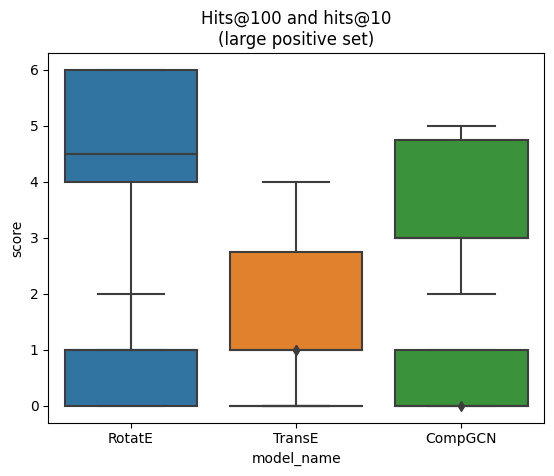

In [22]:
import seaborn as sns

sns.boxplot(score_dfs[0], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set)"
)
sns.boxplot(score_dfs[0], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

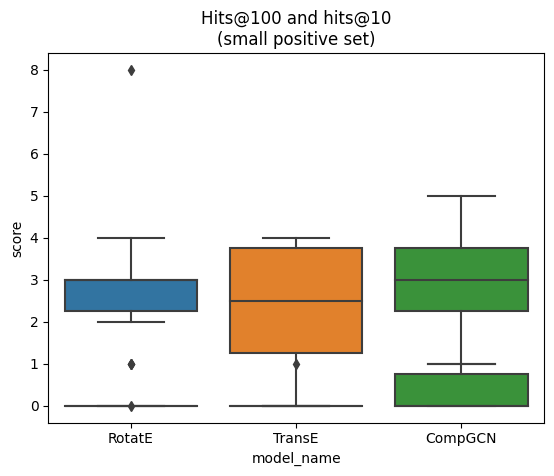

In [23]:
import seaborn as sns

sns.boxplot(score_dfs[1], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(small positive set)"
)
sns.boxplot(score_dfs[1], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

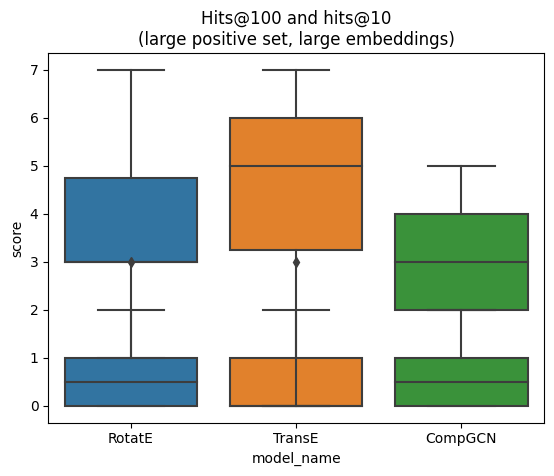

In [24]:
import seaborn as sns

sns.boxplot(score_dfs[2], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, large embeddings)"
)
sns.boxplot(score_dfs[2], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

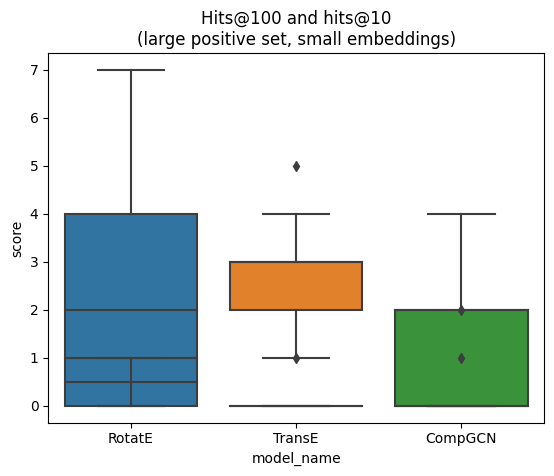

In [25]:
import seaborn as sns

sns.boxplot(score_dfs[3], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, small embeddings)"
)
sns.boxplot(score_dfs[3], x="model_name", y="score100_test").set_ylabel("score")

In [26]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / "score_df.csv", index_col=0))
plot_dfs = []
for ds, score_df in zip(
    ("large", "small", "large_embeddings", "large_embeddings_small"), score_dfs
):
    plot_df = score_df[["model_name", "score10_test", "score100_test"]].copy()
    plot_df.columns = ["model_name", "hits@10", "hits@100"]
    plot_df["dataset"] = ds
    plot_dfs.append(plot_df)

plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=["model_name", "dataset"])
plot_dfs = {k: v for k, v in plot_df.groupby("model_name")}

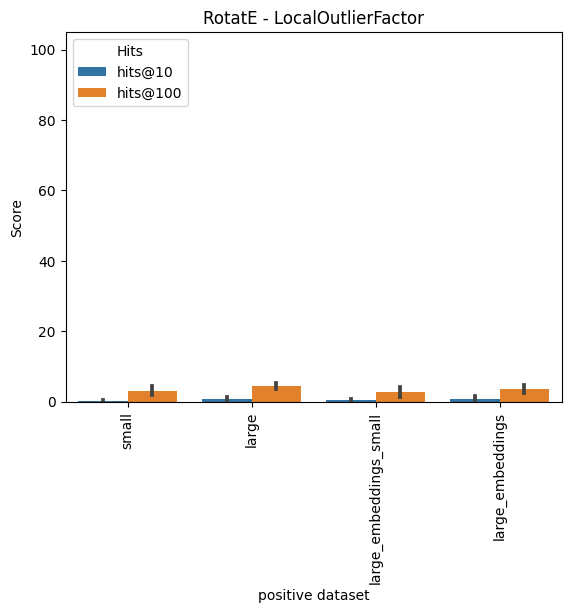

In [27]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "RotatE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

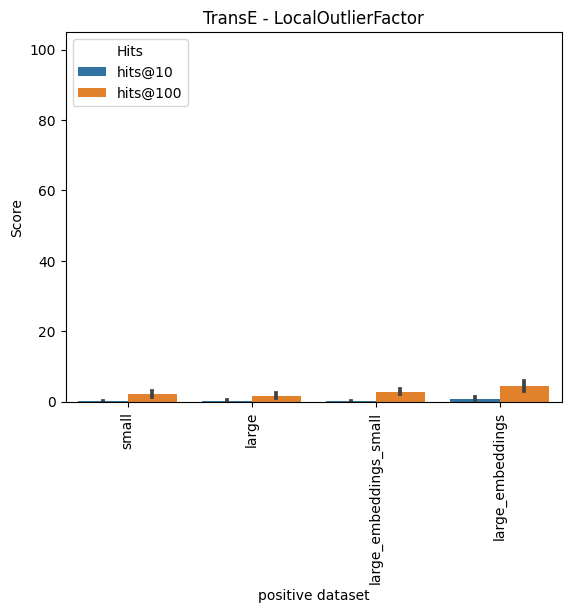

In [28]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "TransE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

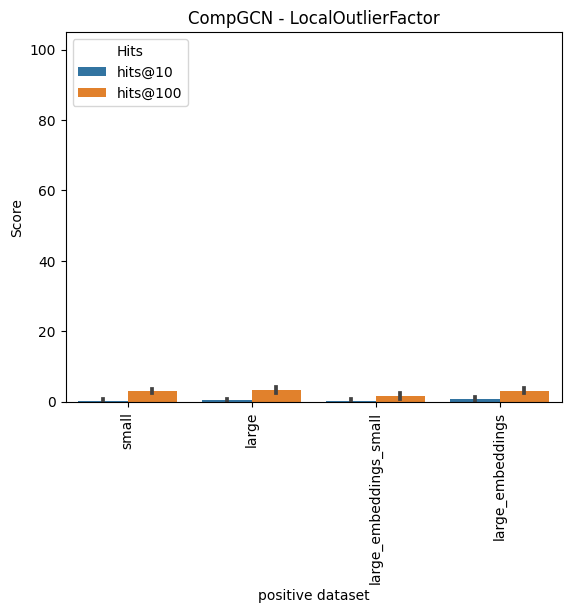

In [29]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "CompGCN"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

In [30]:
proba_dfs = [
    build_proba_df_obl(
        gs, i, mns=MODEL_NAMES, gene_df_file="../topological_features/data/gene_df.csv"
    )
    for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / "proba_df.csv")

In [31]:
proba_df = proba_dfs[0]
proba_df.query("test").sort_values("RotatE_0", ascending=False)

,node_id,gene_name,irr,train,val,test,RotatE_0,RotatE_1,RotatE_2,RotatE_3,...,CompGCN_0,CompGCN_1,CompGCN_2,CompGCN_3,CompGCN_4,CompGCN_5,CompGCN_6,CompGCN_7,CompGCN_8,CompGCN_9
71543,NCBIGENE:11169,WDHD1,False,False,False,True,0.124651,0.041332,0.061785,-8.409901e-01,...,-0.234750,0.017954,-2.851875e-01,0.017633,-0.108845,-5.225372e-02,-0.000957,-0.122333,-0.061383,-0.261890
79668,NCBIGENE:4185,ADAM11,False,False,False,True,0.120076,-0.062983,0.084449,2.944297e-02,...,0.024338,0.004667,3.938544e-02,0.019485,0.014702,-1.300190e+10,0.028319,-0.017357,-0.105624,-0.013168
79403,NCBIGENE:404550,C16orf74,False,False,False,True,0.105148,-0.010033,-0.958829,-2.327197e-01,...,0.025953,0.004381,-7.424200e-02,-0.071596,0.031065,-1.282158e-01,-0.039197,-0.359401,0.004396,0.000000
86400,NCBIGENE:79931,TNIP3,False,False,False,True,0.084483,-0.002335,-0.575969,-5.030513e-03,...,-0.318736,0.007312,-4.748034e-02,0.006181,-0.015927,-5.684030e-02,0.038354,-0.088463,-0.254633,-0.152682
82253,NCBIGENE:55544,RBM38,False,False,False,True,0.074812,-0.003083,0.052394,8.378679e-02,...,0.016613,-0.385832,-1.767685e-01,-0.043644,-0.050096,-2.846885e-02,-0.001132,-0.205487,0.014628,-4.098076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73009,NCBIGENE:143425,SYT9,False,False,False,True,-3.218825,-0.101364,0.104122,-2.034934e-01,...,0.012886,0.008117,2.242184e-02,-0.150576,0.006288,-7.897341e-02,-0.191487,0.027400,-0.037926,-0.009484
89095,NCBIGENE:9495,AKAP5,False,False,False,True,-4.129175,0.002500,0.106289,-4.117942e-02,...,0.019346,-0.118896,2.205449e-02,-0.020063,-0.422690,-1.603940e-01,-0.141345,-0.061434,-0.217312,-0.565602
74870,NCBIGENE:2257,FGF12,False,False,False,True,-4.643016,-0.051332,0.000000,-1.753318e-01,...,0.023209,0.040259,2.895659e-02,0.022195,-0.039817,-1.467231e+10,-0.050654,-0.028680,-0.248172,0.119783
74204,NCBIGENE:196385,DNAH10,False,False,False,True,-5.241100,0.021772,0.000000,-4.791331e-02,...,-0.483307,-0.210467,-2.134180e+06,0.019622,-0.081586,-3.871627e-01,-0.016544,0.019579,0.006250,0.057019


In [32]:
for proba_df, score_df, od in zip(proba_dfs, score_dfs, output_dirs):
    proba_df.to_csv(od / "proba_df.csv")
    proba_df.query("test").to_csv(od / "proba_df_test.csv")
    score_df.to_csv(od / "score_df.csv")

    for mn in MODEL_NAMES:
        score_cols = [c for c in proba_df.columns if c.startswith(f"{mn}_")]
        tmp_df = proba_df[
            ["node_id", "gene_name", "irr", "train", "val", "test", *score_cols]
        ]
        tmp_df.to_csv(od / f"proba_df_{mn}.csv")
        tmp_df_test = tmp_df.query("test")
        tmp_df_test.to_csv(od / f"proba_df_test_{mn}.csv")

        genes_100 = build_ranked_lists(tmp_df, prefix=mn)
        genes_100.to_csv(od / f"genes_100_{mn}.csv", index=False)
        genes_100_test = build_ranked_lists(tmp_df_test, prefix=mn)
        genes_100_test.to_csv(od / f"genes_100_test_{mn}.csv", index=False)

        ds = "test"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{ds}_{mn}.csv", index_label="score")

        ds = "all"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{mn}.csv", index_label="score")